- 첫번째는 문법, 구조를 익히기
- 두번째는 이해하면서 다음 내용들을 예측하기
- 세번째는 좀 더 발전할 수 있는 방향을 생각 및 실천

- 순서
    1. data set 확인 (null data 확인)
    2. 데이터의 특성들을 분석해서 통찰력 얻기 (데이터 분포, 상관관계들을 보면서 모델을 어떻게 구현할지)
    3. feature engineering : 모델의 성능을 높이기 (one-hot encoding, 구간으로 나누기, null data 넣기 등)
    4. model 만들기
    5. 모델 학습 및 예측 - 평가

## 이진분류 문제 (target이 이진분류로 되어 있음)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale = 2.5)
import missingno as msno

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- feature에서  nulldata 찾기
    - msno 활용

<AxesSubplot:>

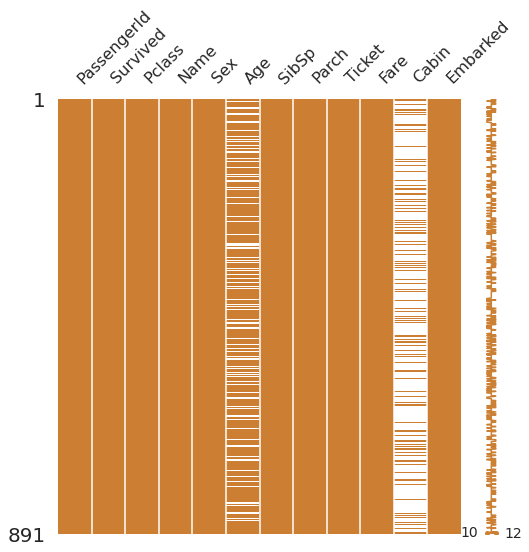

In [4]:
msno.matrix(df = df_train.iloc[:, :], figsize = (8,8), color = (0.8, 0.5, 0.2))

<AxesSubplot:>

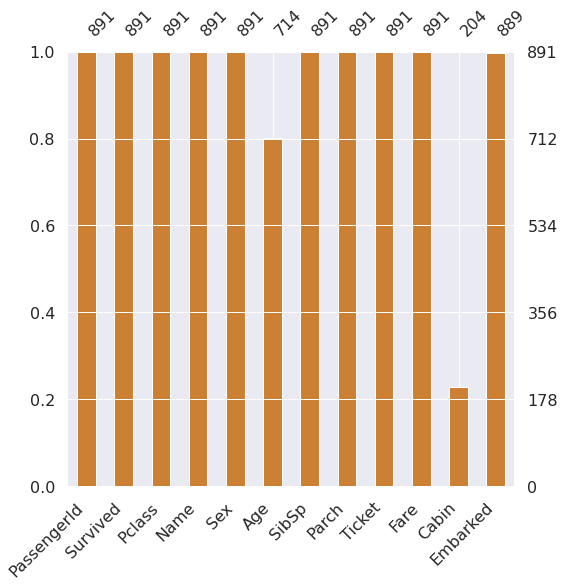

In [5]:
msno.bar(df = df_train.iloc[:, :], figsize = (8,8), color = (0.8, 0.5, 0.2))

### target label 확인
- 이진분류 문제이므로 0과 1이 어떻게 분포되어 있는지에 따라서 모델의 평가방법이 달라짐

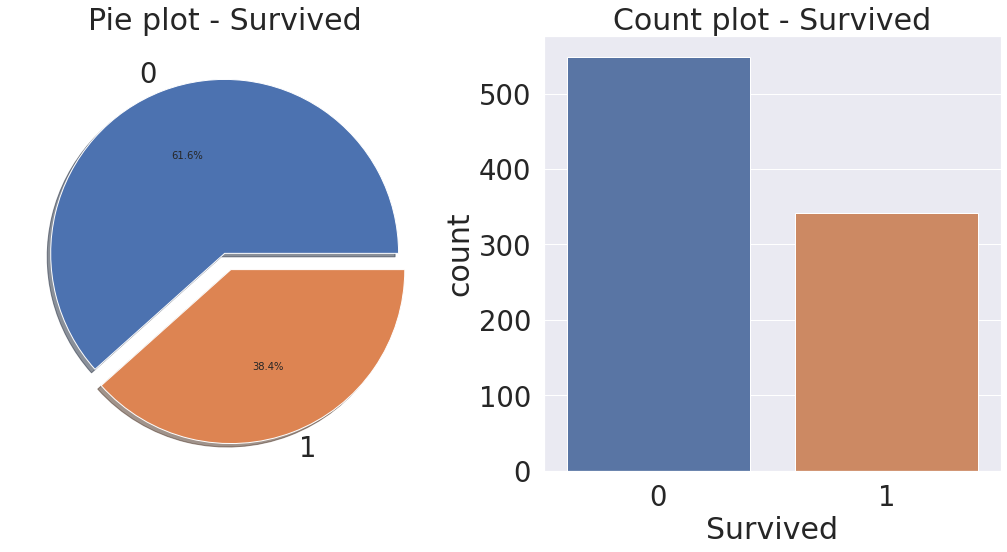

In [6]:
f, ax = plt.subplots(1,2,figsize = (18,8))
df_train['Survived'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data = df_train, ax = ax[1])
ax[1].set_title('Count plot - Survived')
plt.show()
# 나에게 막대그래프가 더 보기 좋은거 같음

### Data Analysis
- 각 특성들을 확인 및 분석

In [7]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [8]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = True).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [9]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins = True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


<AxesSubplot:xlabel='Pclass'>

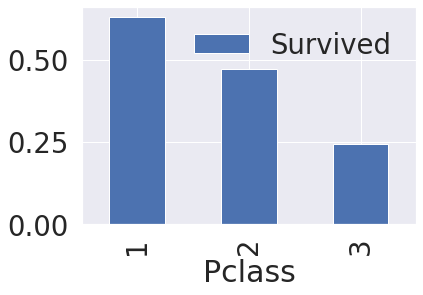

In [10]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index = True).mean().sort_values(by = 'Survived', ascending = False).plot.bar()

- Pclass가 높을수록 생존률 증가
### Sex

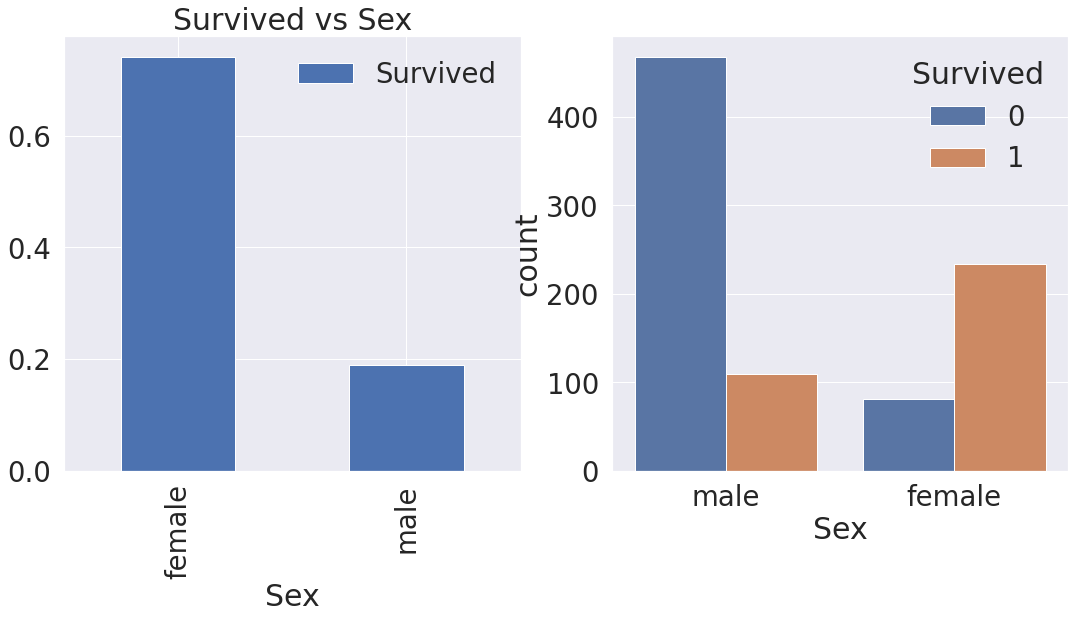

In [11]:
f, ax = plt.subplots(1,2,figsize = (18,8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index = True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', data = df_train, hue = 'Survived' ,ax= ax[1])
plt.show()

In [12]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins = True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


In [13]:
df_train[['Sex', 'Survived']].groupby(['Sex'],as_index = True).mean().sort_values(by = 'Survived', ascending = False)

,Survived
Sex,
female,0.742038
male,0.188908


- 여자의 생존확률이 더 높다

### 두가지 특성을 가지고 생존률 비교 (Sex, Pclass)

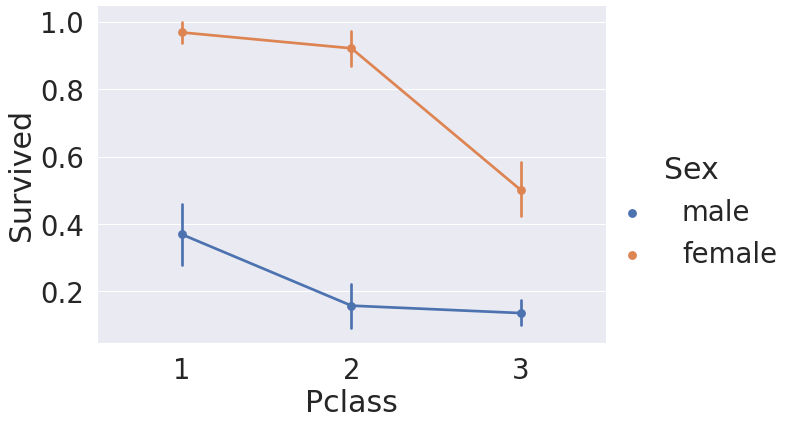

In [14]:
sns.factorplot('Pclass', 'Survived', hue = 'Sex', data = df_train, size = 6, aspect = 1.5)
# 3개의 차원 그리기

- 모든 Pclass에서 여자가 살 확률이 더 높음
### Age 분석
- 나이를 히스토그램으로 보는이유
    - 일련된 데이터니까.. 보기 편함
    - Pclass와 Sex는 개수가 정해져 있음 (2~3개)

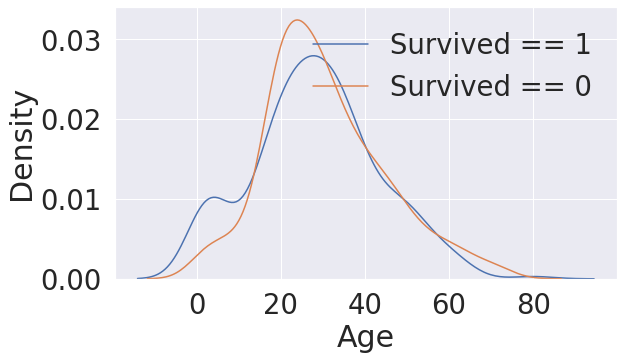

In [15]:
fig, ax = plt.subplots(1,1,figsize = (9,5))
sns.kdeplot(df_train[df_train['Survived']==1]['Age'], ax = ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'], ax = ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

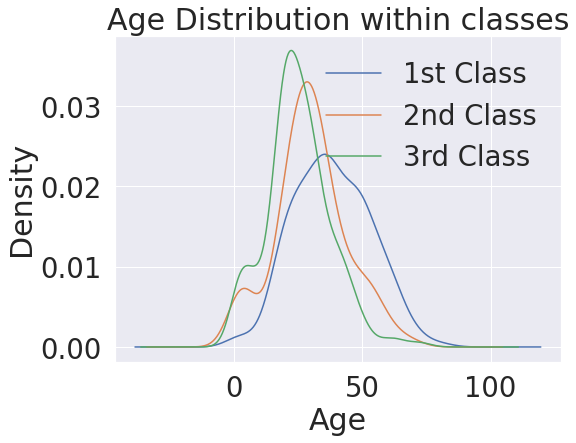

In [16]:
plt.figure(figsize = (8,6))
df_train['Age'][df_train['Pclass']==1].plot(kind = 'kde')
df_train['Age'][df_train['Pclass']==2].plot(kind = 'kde')
df_train['Age'][df_train['Pclass']== 3].plot(kind = 'kde')
plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

- 나이가 어릴수록 더 살 확률이 있음
### Sex, Pclass, Age 모두 확인

<AxesSubplot:xlabel='Sex', ylabel='Age'>

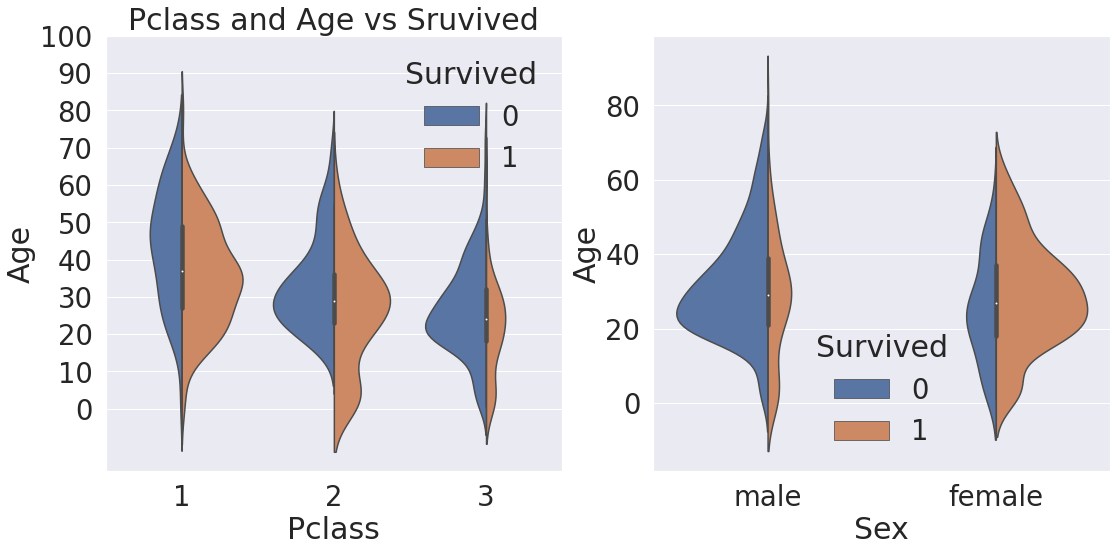

In [17]:
f, ax = plt.subplots(1,2,figsize = (18,8))
sns.violinplot('Pclass', 'Age', hue = 'Survived', data = df_train, scale = 'count',split = True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Sruvived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Sex', 'Age', hue = 'Survived', data = df_train, scale = 'count', split = True, ax = ax[1] )

## embarked
- 문자로 되어있음, 막대그래프로 표시

<AxesSubplot:xlabel='Embarked'>

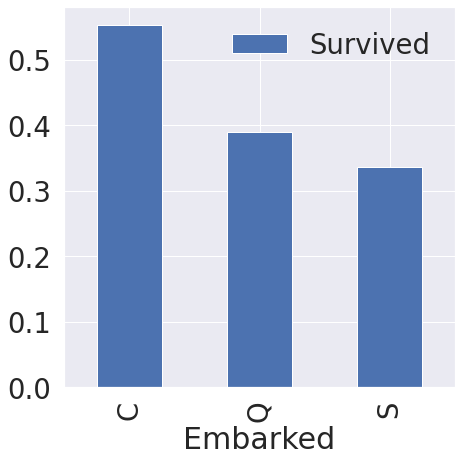

In [18]:
f, ax = plt.subplots(1,1,figsize = (7,7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index = True).mean().sort_values(by = 'Survived', ascending = False).plot.bar(ax = ax)

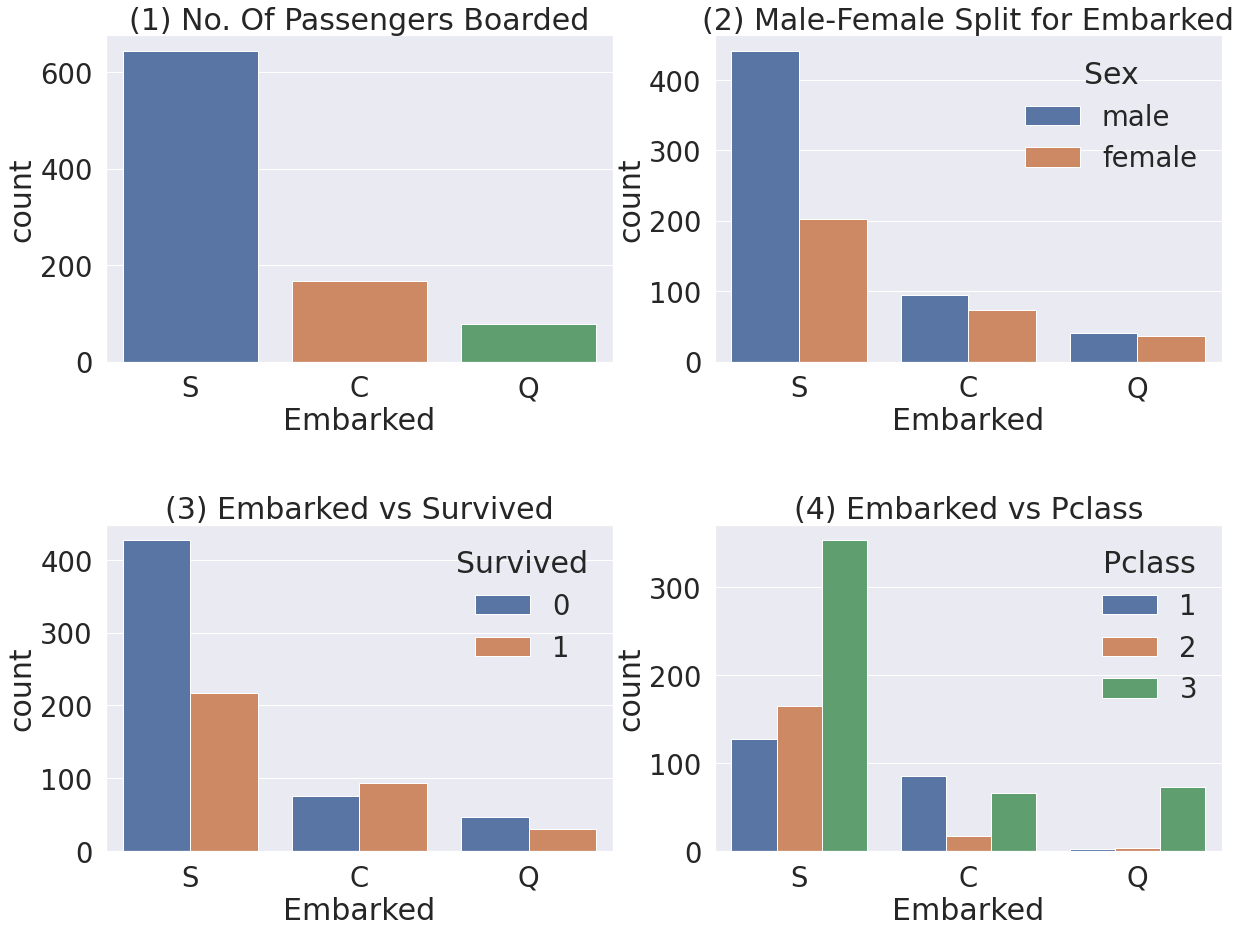

In [19]:
f, ax = plt.subplots(2,2,figsize = (20,15))
sns.countplot('Embarked', data = df_train, ax = ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked', hue = 'Sex', data = df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Family - SibSp(자식) + Parch(부모)
- 일련된 서수 데이터, countplot 사용 가능

In [20]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

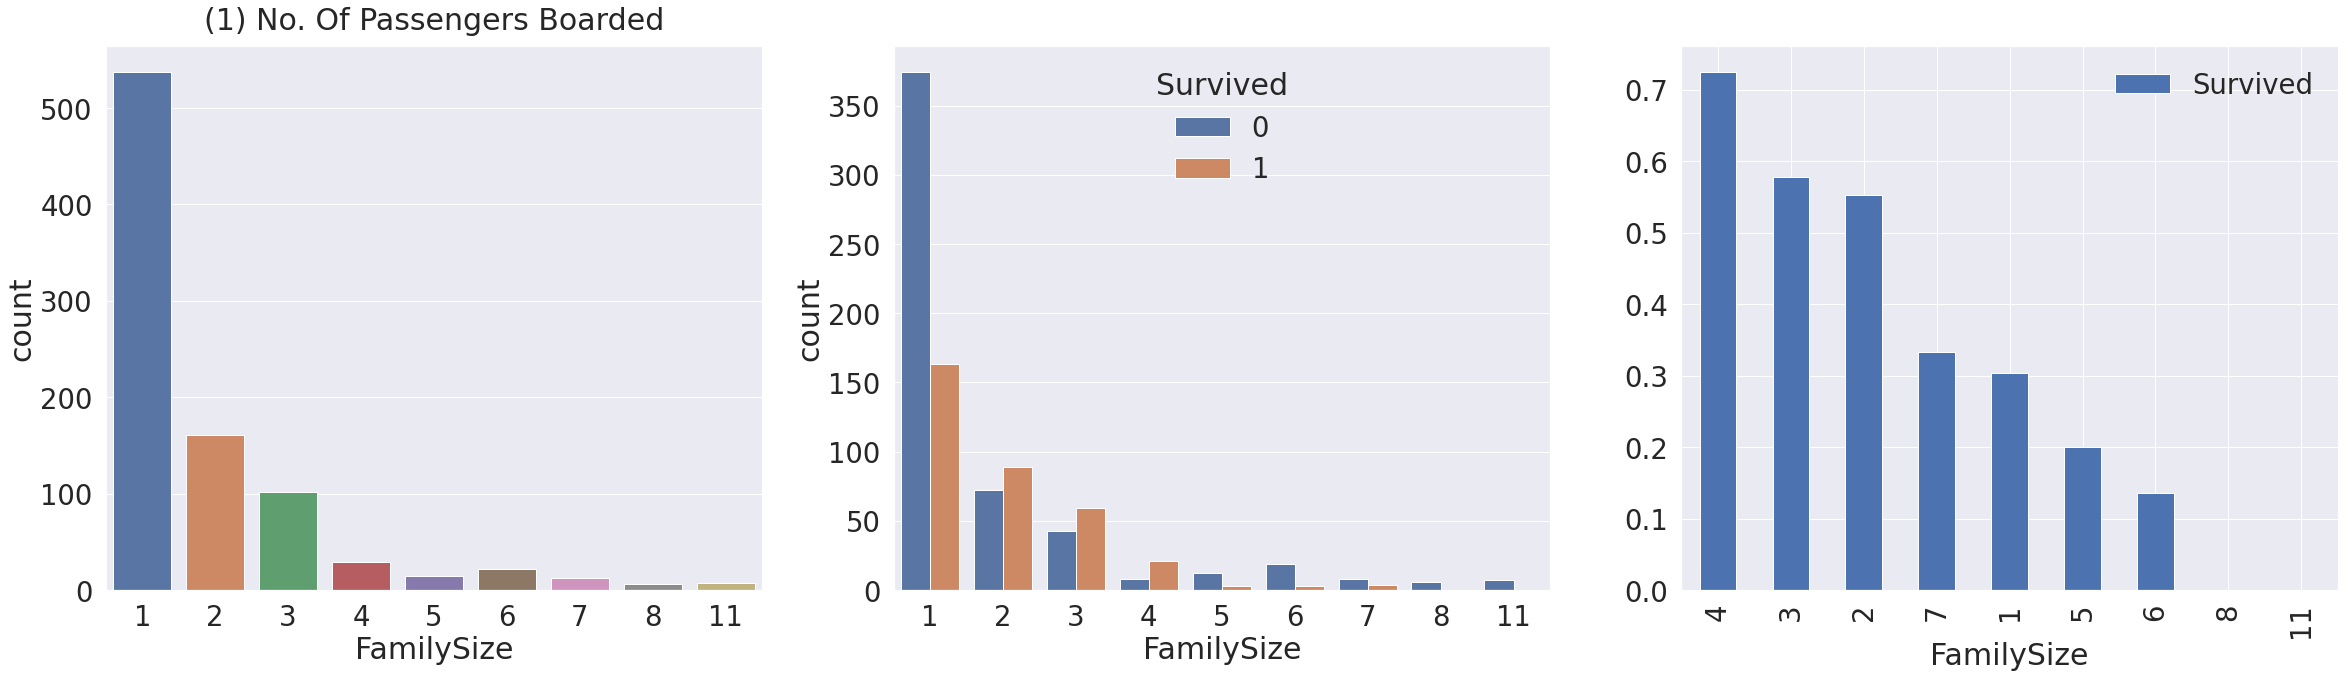

In [21]:
f, ax = plt.subplots(1,3,figsize = (40,10))
sns.countplot('FamilySize', data = df_train, ax = ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot('FamilySize', data = df_train, hue = 'Survived', ax = ax[1])

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index = True).mean().sort_values(by = 'Survived', ascending = False).plot.bar(ax=ax[2])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

- 가족단위가 작을수록 생존확률이 올라감
## Fare
- 나이와 같이 일련된 데이터, 히스토그램들이 잘 어울림

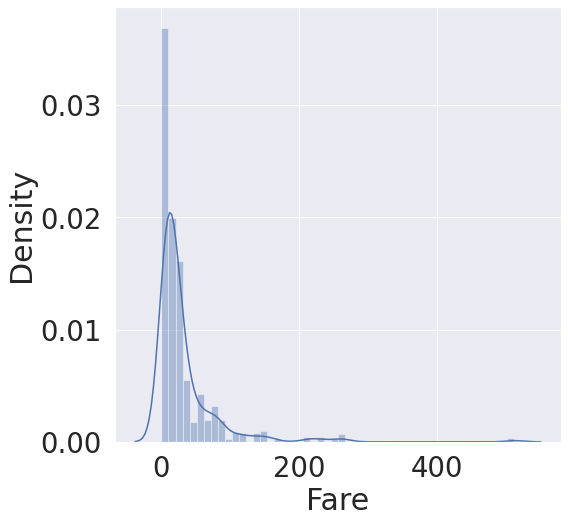

In [22]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
g = sns.distplot(df_train['Fare'], color = 'b', label = 'Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax = ax)

- 데이터가 너무 비대칭이여서 데이터 전처리를 해주어야 함, 주로 표준점수로 하거나 log를 사용
    - feature 공학에서 다룰예정

## Cabin
- null데이터가 너무 많음, 강의에서 포함 안시킴, 
## Ticket 
- 내가 스스로 공부하라고 던져준 특성
